# Turkey

In [243]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np
import math
import pandas as pd

from IPython.display import Image

To do:
    
estimate/research ideal turkey temp- outside (upper bound outside of meat burning temp: https://modernistcuisine.com/2013/03/the-maillard-reaction/)

work on r values and fine tune, see if we can ground them in anything more real world

finish computational essay
   - write interpretation
   - make separate "synthesis" and "results" sections?
   - fix up comments 
   - add in assumptions like that a turkey's thigh temp would correspond to inner turkey temp
   - talk about kelvin and farenheit

## Question

### When cooking a 15 pound turkey, what is the best length of time to cook it for and best oven temperature to cook it at?

With the upcoming Thanksgiving season, the concern of cooking the perfect turkey is on many families’ minds.
If you cook a turkey at too high of an oven temperature, the outside cooks faster than the inside, and can cause burning or undercooking of the inside of the turkey. On the other hand, if you cook a turkey at too low an oven temperature, it takes a very long time to cook, and you do not get a good crispy outside. Also, if you cook a turkey for too little time you risk undercooking and if you cook a turkey for too long it can cause dryness and burning. It’s important to balance time and oven temperature in order to cook a good thanksgiving turkey, and so we wanted to explore the ideal factors.


## Model

We modeled the turkey as a sphere made of two layers. The spherical turkey weighed 15 lbs and has a diameter of 34 centimeters -- both determined from the pan size listed in this turkey recipe: [https://blog.metrokitchen.com/roasting-pan-guide/]. The outer layer of the turkey was assumed to have a thickness of 2 cm. The heat of the oven was kept constant within a single run of the simulation, and heat was modeled to be transferred via conduction between the air of the oven and the outer layer of the turkey, and between the outer and inner layers.

In [244]:
def make_system(params, T_oven, T_init, t_end):
    """Make a system object for the turkey model.
    inner is inner temperature of turkey
    outer is outer temperature of turkey
    
    params is the r and C values for thermal compartments
    t_end is when the turkey is taken out of the oven
    )
    
    returns: System object
    """
    #initial temperatures are of the temperature of pre-heated oven
    init = State(T_inner=T_init, T_outer=T_init)

    return System(init=init, t0=0, t_end=t_end, T_oven=T_oven,
                  params = params)

The C value of each layer was estimated as the mass multiplied by the specific heat of turkey meat (3.53 kJ/kg\*K)from ashrae.org's "Thermal Properties of Foods" and the R values were assumed to be the same and were estimated so the temperature of the internal layer over time would match that of an actual turkey being cooked in this paper: http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf
https://www.researchgate.net/file.PostFileLoader.html?id=57dc0df6dc332d6c7a2b0e94&assetKey=AS%3A406964417908742%401474039286881

In [245]:
params = Params(
    r_inner = 0.0015, #Km^2/W
    r_outer = 0.012, #Km^2/W
    c_inner = 16490, #J/K
    c_outer = 7520); #J/K
#attempting to do two different r values
#.0058 when r's match
'''params = Params(
    r_outer = 0.006, #Km^2/W
    r_inner = 0.006, #Km^2/W
    c_inner = 10450, #J/K
    c_outer = 5330, #J/K
    )''';

The functions convert_k_to_f to assist in plot clarity. convert_k_to_f converts the kelvin temperatures from calculations into farenheit for plotting.

In [246]:
def convert_k_to_f(k):
    return (k-273)*(9/5) + 32

To calculate the temperature derivative with respect to time of the outer and inner layers (dodt and didt respectively), we used the formulas
Flux = (T_ext - T) / R
And
dT/dt = net flux/C
Where R = thermal resistivity and C = thermal mass.

In [247]:
def slope_func(state, t, system):
    """Makes the differential equations.
    
    state: State (t_inner, t_outer)
    t: time
    system: System object
    
    returns: didt, dodt
    """
    
    unpack(system)
    r_outer, r_inner, c_inner, c_outer = params
    T_inner, T_outer = state
    
    o_flux = (T_oven-T_outer)/r_outer
    i_flux = (T_outer-T_inner)/r_inner
    
    dodt = (o_flux-i_flux)/c_outer
    
    #compute inner temperature change
    didt = i_flux/c_inner
    
    return didt, dodt

Plot results is created to aid in plotting our model's inner and outer turkey temperature and data from an article (for validation).

In [248]:
def plot_results_validation(inner, outer, validation):
    """Plot the inner and outer temperatures of the Turkey
    to compare to the validation curve
    
    inner: TimeSeries
    outer: TimeSeries
    validation: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    validation_f=convert_k_to_f(validation)
    plot(inner_f, '-', label='Inner Temperature')
    plot(outer_f, '-', label='Outer Temperature')
    plot(validation_f, '-', label='Validation')
    
    decorate(xlabel='Minutes',
             ylabel='Temperature (Degrees F)',
             title = 'Cooking Time of a Turkey')

### Validation

To calibrate the r values and verify that the curve for turkey cooking is correct, the inner temperatures of the turkey over time are plotted and compared to the shape of the curve from this article: [http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf] and the final temperature inner temp at 3hrs 20 mins when the turkey should be cooked is compared to that of this recipe: [https://www.allrecipes.com/recipe/166160/juicy-thanksgiving-turkey/ ].

The plot below is from the article. Its data points were translated over manually to a TimeSeries to then be plotted as validation.

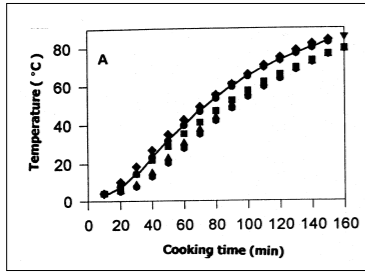

In [249]:
Image("images/turkey_temp_graph.png")

#### Legend: 

#### circle = thigh of 6.8kg calculated values from artile (best fit line matches to this)

#### hexagon = thigh of 7.1kg fresh turkey 

6.8kg is 15 pounds (the weight of our model's turkey). The graph from the article shows the curve for the inner temperature of a turkey (thigh in this case).

The data points were found and written down manually into a TimeSeries, and then plotted as an individual graph to make sure it was an accurate representation of the article data.

In [250]:
t_validation = [10, 20, 40, 60, 80, 90, 95, 100, 120, 140, 160] #minutes
inner_T_valid_C = [1, 5, 20, 40, 55, 63, 66, 68, 75, 80, 85] #degrees celcius
data_validation_C = TimeSeries(inner_T_valid_C,t_validation)

,values
10,1
20,5
40,20
60,40
80,55
90,63
95,66
100,68
120,75
140,80


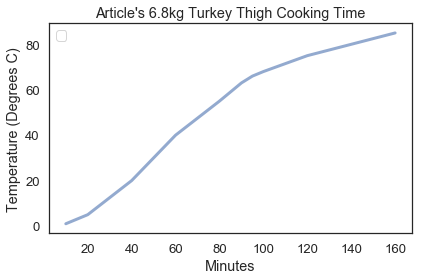

In [251]:
plot(data_validation_C)
decorate(xlabel='Minutes',
        ylabel='Temperature (Degrees C)',
        title = 'Article\'s 6.8kg Turkey Thigh Cooking Time')

Since the article data was in celcius, the temperature was converted to kelvin to match with the units of our model temperatures.

In [252]:
inner_T_validation = []
for temp in inner_T_valid_C:
    temp_k = temp + 273
    inner_T_validation.append(temp_k)
data_validation = TimeSeries(inner_T_validation,t_validation)

,values
10,274
20,278
40,293
60,313
80,328
90,336
95,339
100,341
120,348
140,353


The validation curve is then plotted with the model temperatures. The model temperatures are calculated using the params, make_system, and slope_func (shown above) and the ode_solver below.

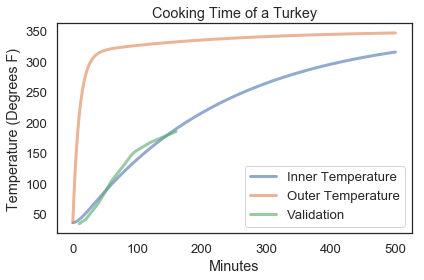

In [253]:
system = make_system(params,450,275,500)
results, details = run_ode_solver(system,slope_func,max_step=1)
plot_results_validation(results.T_inner, results.T_outer, data_validation)#got rid of outer temporarily
#plot(results.T_inner) 
#plotting the results before converting has a different slope. 
#i guess this makes sense but are we okay with that

Then, for additional verification and to fine tune the r values, the recipe values were compared to our model's values. The recipe for a 15 pound turkey has the inner temperature of the turkey at 180 degrees farenheit when it is removed from the oven after 200 minutes (3 hrs 20 mins). For our verification plot, the inner temperature of the turkey is 180 degrees farenheit at 200 minutes.

### Sweep

Once the temperatures are verified on a graph, a sweepseries of oven temperatures is made. The sweepseries is used to make a graph of the oven temperature and the corresponding inner temperature and outer temperature of the turkey at given times.

In [254]:
def sweep_temp(slope_func, min_temp, max_temp, time, num_runs):
    '''Sweep oven temperature
    
    min_temp: lowest temperature 
    max_temp: highest temperature 
    
    Returns: Sweepseries
    '''
    
    temp_array = linspace(min_temp, max_temp, num_runs)
    sweep = SweepSeries()
    
    colors = ['red','orange','yellow','green','blue','purple']
    color_counter = 0
    
    for temp in temp_array:
        system=make_system(params,temp,275,time) #make_system(params, T_oven, T_init, t_end)
        results, details = run_ode_solver(system,slope_func,max_step=1)
        plot_results(results.T_inner, results.T_outer, colors[color_counter])
        color_counter += 1
        if color_counter == 6:
           color_counter = 0 
        sweep[temp] = results
    
    return sweep

## Results

Talk about results and stuff.

In [255]:
def plot_results(inner, outer, color):
    """Plot the inner and outer temperatures of the Turkey
    
    inner: TimeSeries
    outer: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    plot(inner_f, '-', color = color)
    plot(outer_f, '-', color = color)
    
    decorate(xlabel='Minutes',
             ylabel='Temperature')

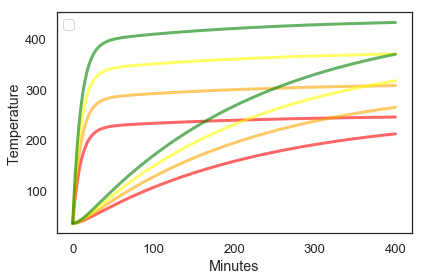

In [260]:
readable_sweep = sweep_temp(slope_func, 394, 500, 400, 4);

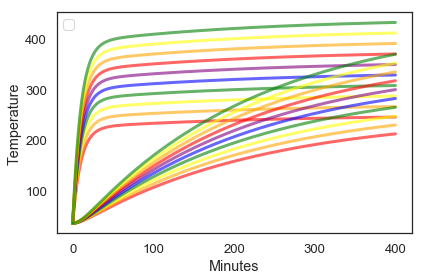

In [258]:
detailed_sweep = readable_sweep = sweep_temp(slope_func, 394, 500, 400, 10)

In [257]:
def get_min(my_list):
    my_min = np.inf
    for item in my_list:
        if item < my_min:
            my_min = item
    return my_min

In [262]:
def make_results_table(sweep, target_temp_k):
    
    '''Determine temperature of outer layer while inner layer 
       is at target temp for each oven temperature in sweep
    
    sweep: SweepSeries containing inner and outer layer temperatures where index is oven temperatures
    target_temp: desired temperature of inner layer, in kelvin
    
    Returns: DataFrame containing corresponding oven temperatures, inner temperatures (close
    to target temperature, and outer temperatures IN FARENHEIT'''
    
    #initialize temperature lists to be displayed in dataframe
    inner_list = pd.Series([])
    outer_list = pd.Series([])
    
    #make list of pairings with 180
    for oven_temp in sweep.index:
        #get inner temp closest to 180
        off_from_180_list=[]
        for temp in sweep[oven_temp].T_inner:
            off_from_180 = abs(target_temp_k - temp)
            if off_from_180 < 1:
                closest_temp = temp
                break
        
        #determine corresponding outer temp to ~180 inner temp
        for index in sweep[oven_temp].T_inner.index:
            if sweep[oven_temp].T_inner[index] == closest_temp:
                corresp_index = index
        corresp_outer = sweep[oven_temp].T_outer[corresp_index]
        
        #add found temperatures to lists
        inner_list = inner_list.append(pd.Series([closest_temp]))
        outer_list = outer_list.append(pd.Series([corresp_outer]))

    #convert inner and outer temperature matches to f and compile into dataframe
    table_final = pd.DataFrame({'Oven Temperature':convert_k_to_f(sweep.index), 
                                'Inner Temperature':convert_k_to_f(inner_list), 
                                'Outer Temperature':convert_k_to_f(outer_list)})
    
    return table_final

In [261]:
results_table = make_results_table(detailed_sweep, 355)

,Oven Temperature,Inner Temperature,Outer Temperature
0,249.8,178.080469,241.457621
0,271.0,178.019603,260.184568
0,292.2,177.856014,278.899565
0,313.4,178.042010,297.655219
0,334.6,178.119760,316.398253
0,355.8,178.206321,335.142214
0,377.0,178.112153,353.864887
0,398.2,178.296671,372.619436
0,419.4,178.171610,391.336843
0,440.6,177.961696,410.042392


## Research stuff:

### From thermal properities of food pdf (in google doc): 
Turkey specific heat above freezing 3.53 kJ/(kg·K)
Turkey, breast 0.496 W/(m·K) thermal conductivity at 3 degrees C

### From turkey cooking article:
http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf data from turkey
 118°C oven temp, with the oven at room temperature starting their experiment
 thermal conductivity 0.461 W/m K
 surface heat transfer coefficient of 19.252 W/m2K

https://www.allrecipes.com/recipe/166160/juicy-thanksgiving-turkey/
This is the recipe we got "180" from

## Interpretation

- Assumptions we made
- the answer
- what the results mean for the real world
- what mistakes we made and how we would fix them in the future
- what improvements we could make in general